<a href="https://colab.research.google.com/github/audi1712/DL-Project-CS-F425-/blob/main/Final_Submission%20(Group-9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DeepLearning (CS F425) Major Project
## Final submission
Name:- Adithya Manjunatha

Id:- 2019A7PS0118G


#MODNet
MODNet is a light-weight model
for real-time trimap-free portrait matting using Objective Decomposition.

https://arxiv.org/pdf/2011.11961.pdf

In [ ]:
!nvidia-smi

Sun May 15 14:06:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset
The dataset used in this notebook is a Human segmentation dataset from AISegment.com. It contains 34427 images with their respective matting results.

The dataset contains two folders, 'clip_img' consisting of all the original images with size of 600*800 in '.jpg' format, and a 'matting' folder with the respective matting results of the images in '.png' format.

https://www.kaggle.com/laurentmih/aisegmentcom-matting-human-datasets

Note:- Please upload kaggle.json to "/content/" to continue. (Downloads zip file of size 28.8 GB into runtime)


In [ ]:
!mkdir /root/.kaggle/

In [ ]:
!mv kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d laurentmih/aisegmentcom-matting-human-datasets

100% 28.8G/28.8G [08:55<00:00, 84.6MB/s]
100% 28.8G/28.8G [08:55<00:00, 57.6MB/s]


In [ ]:
import zipfile
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
from tqdm import tqdm
import torch
from PIL import Image,ImageFilter,ImageOps
from io import BytesIO
import pickle
import albumentations as A
import cv2
from torch.utils.data import random_split
from torchsummary import summary
import torch.nn as nn
import torchvision

In [ ]:
torch.manual_seed(171201)

# Data Loading and Pre-Processing

##Loading

Since the dataset is large with inputs and outputs being images, it cannot be loaded all at once in the runtime without crashing. Therefore we had to make a custom dataset using 

```
torch.utils.data.Dataset
torch.utils.data.DataLoader
```
This custom dataset reads the files from the zip file downloaded earlier and does the required preprocessing.
The DataLoader is then used to load the data when required in batches of 8.


##Preprocessing


1.   The original image is resized to 256x256 due to computational constraints, and the axes are swapped from channels last to channels first as expected by pytorch.
2.   The matting result is converted to it's alpha matte by taking only the fourth channel (as specified in the discription of the dataset).
3.   The alpha matte is downsampled to 32x32 and blurred to obtain the semantics.
4.   The alpha matte is dilated and then eroded and multiplied with the original alpha matte in order to get the details.
5.   This data is then augmented using albumentations.
```
A.Compose([
             A.HorizontalFlip(),
             A.RandomBrightnessContrast(0.2,0.2),
             A.ShiftScaleRotate(0.1,(-0.5,0),border_mode = cv2.BORDER_CONSTANT) 
             ])
```

The data is preprocessed and saved in the same zipped file, to save time during training.

##Train-Test-Validation split
25000 of the 34426 images are used for training,

5000 images for validation,

and the remaining 4426 are used for testing.





In [ ]:
class Mat_Data_PreProc():
  '''Class for preprocessing and saving'''
  def __init__(self):
    self.Data_file = zipfile.ZipFile("/content/aisegmentcom-matting-human-datasets.zip","a")
    temp0 = [x for x in self.Data_file.namelist() if x[:9] == "clip_img/"]
    temp = [y for y in self.Data_file.namelist() if y[:8]=="matting/"]
    self.images = []
    self.masks = []    
    for y in temp0:
      path_mat = y.replace('clip_img','matting').replace('clip','matting').replace('.jpg','.png')
      if path_mat not in temp:
        print("Mask not found:-")
        print(y)
        print(path_mat)
        print('.')
      else:
        self.images.append(y)
        self.masks.append(path_mat)
      
    del temp
    del temp0
    if len(self.images)!=len(self.masks):
      raise Exception("Less masks!!!")
  
  def __len__(self):
    return len(self.images)
  def proc(self, index):
    img_D = self.Data_file.read(self.images[index])
    mat_D = self.Data_file.read(self.masks[index])
    img = Image.open(BytesIO(img_D)).resize((256,256))
    #img = np.array(img)/255
    mat = Image.open(BytesIO(mat_D)).resize((256,256))
    mat = np.array(mat)[:,:,3]
    mat[mat<128] = 0
    mat[mat>=128] = 1
    mat = Image.fromarray(mat)
    #img = Image.fromarray(img)
    mat1 = mat.resize((32,32))
    mat1 = mat1.filter(ImageFilter.GaussianBlur())
    mat2 = mat.filter(ImageFilter.MaxFilter(3))
    mat3 = mat.filter(ImageFilter.MinFilter(3))
    #img = Image.fromarray(img)
    mat2 = np.array(mat2) - np.array(mat3)
    mat2 = Image.fromarray(mat2)




    img_F = self.Data_file.open(self.images[index][:8]+"256" + self.images[index][8:],mode = 'w')
    #print(np.array(img).shape)
    img.save(img_F,"JPEG")
    img_F.close()

    mat_F = self.Data_file.open(self.masks[index][:7]+"256" + self.masks[index][7:],mode = 'w')
    mat.save(mat_F, "PNG")
    mat_F.close()

    mat1_F = self.Data_file.open(self.masks[index][:7]+"32" + self.masks[index][7:],mode = 'w')
    mat1.save(mat1_F, "PNG")
    mat1_F.close()

    mat2_F = self.Data_file.open(self.masks[index][:7]+"256_det" + self.masks[index][7:],mode = 'w')
    #mat2 = Image.fromarray(np.array(mat2) - np.array(mat3))
    mat2.save(mat2_F, "PNG")
    mat2_F.close()
  
  def viewimg(self,index):
    img_D = self.Data_file.read(self.images[index][:8]+"256" + self.images[index][8:])
    mat_D = self.Data_file.read(self.masks[index][:7]+"256" + self.masks[index][7:])
    sem_D = self.Data_file.read(self.masks[index][:7]+"32" + self.masks[index][7:])
    det_D = self.Data_file.read(self.masks[index][:7]+"256_det" + self.masks[index][7:])
    img = Image.open(BytesIO(img_D))
    mat = Image.open(BytesIO(mat_D))
    sem = Image.open(BytesIO(sem_D))
    det = Image.open(BytesIO(det_D))

    print(np.array(img).shape)
    print(np.array(mat).shape)
    print(np.array(sem).shape)
    print(np.array(det).shape)




    plt.subplot(121)
    plt.title("Image")
    plt.imshow(np.array(img)/255)
    plt.subplot(122)
    plt.title("Matte")
    plt.imshow(np.array(mat),"gray")

    plt.show()

    plt.subplot(121)
    plt.title("Sp")
    plt.imshow(np.array(sem),"gray")
    plt.subplot(122)
    plt.title("Dp")
    plt.imshow(np.array(det),"gray")

    plt.show()

In [ ]:
x = Mat_Data_PreProc()

Mask not found:-
clip_img/1803241125/clip_00000000/._1803241125-00000005.jpg
matting/1803241125/matting_00000000/._1803241125-00000005.png
.


In [ ]:
for i in tqdm(range(x.__len__())):
  x.proc(i)

100%|██████████| 34426/34426 [32:30<00:00, 17.65it/s]


(256, 256, 3)
(256, 256)
(32, 32)
(256, 256)


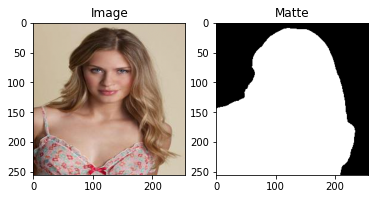

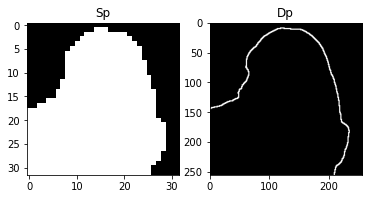

In [ ]:
#preprocessed output
x.viewimg(4000)

In [ ]:
x.Data_file.close()

In [ ]:
class Mat_Data(Dataset):
  def __init__(self):
    self.Data_file = zipfile.ZipFile("/content/aisegmentcom-matting-human-datasets.zip","r")
    temp0 = [x for x in self.Data_file.namelist() if x[:9] == "clip_img/"]
    temp = [y for y in self.Data_file.namelist() if y[:8]=="matting/"]
    self.images = []
    self.masks = []
    self.transforms = A.Compose([
                                 A.HorizontalFlip(),
                                 A.RandomBrightnessContrast(0.2,0.2),
                                 A.ShiftScaleRotate(0.1,(-0.5,0),border_mode = cv2.BORDER_CONSTANT)
                                 
    ])
    for y in temp0:
      path_mat = y.replace('clip_img','matting').replace('clip','matting').replace('.jpg','.png')
      if path_mat not in temp:
        print("Mask not found:-")
        print(y)
        print(path_mat)
        print('.')
      else:
        self.images.append(y)
        self.masks.append(path_mat)
      
    del temp
    del temp0
    if len(self.images)!=len(self.masks):
      raise Exception("Less masks!!!")
  
  def __len__(self):
    return len(self.images)
  def __getitem__(self, index):
    img_D = self.Data_file.read(self.images[index][:8]+"256" + self.images[index][8:])
    mat_D = self.Data_file.read(self.masks[index][:7]+"256" + self.masks[index][7:])
    sem_D = self.Data_file.read(self.masks[index][:7]+"32" + self.masks[index][7:])
    det_D = self.Data_file.read(self.masks[index][:7]+"256_det" + self.masks[index][7:])
    img = Image.open(BytesIO(img_D))
    mat = Image.open(BytesIO(mat_D))
    sem = Image.open(BytesIO(sem_D))
    det = Image.open(BytesIO(det_D))
    img = np.array(img)
    mat = np.array(mat)
    sem = np.array(sem)
    det = np.array(det)
    transformed = self.transforms(image = img,masks = [mat,sem,det])
    img = transformed["image"]
    mat,sem,det = transformed["masks"]
    img = torch.tensor(img/255,dtype = torch.float).permute(2,0,1).float().to("cuda")
    mat = torch.tensor(mat,dtype = torch.float).unsqueeze(0).float().to("cuda")
    mat1 = torch.tensor(sem,dtype = torch.float).unsqueeze(0).float().to("cuda")
    mat2 = torch.tensor(det,dtype = torch.float).unsqueeze(0).float().to("cuda")
    return img,[mat,mat1,mat2]

    




In [ ]:
train_ds = Mat_Data()

Mask not found:-
clip_img/1803241125/clip_00000000/._1803241125-00000005.jpg
matting/1803241125/matting_00000000/._1803241125-00000005.png
.


In [ ]:
train_ds,val_ds = random_split(train_ds,[25000,9426])
val_ds,test_ds = random_split(val_ds,[5000,4426])


(256, 256, 3)
(256, 256)
(32, 32)
(256, 256)


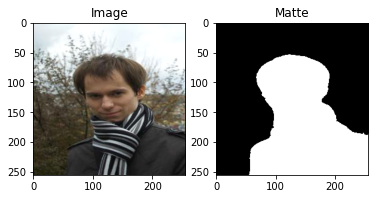

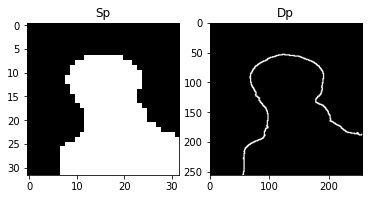

In [ ]:
t = train_ds.__getitem__(2000)
a = t[0].cpu().detach().permute(1,2,0).numpy()
b = t[1][0].cpu().detach().permute(1,2,0).squeeze(2).numpy()
c = t[1][1].cpu().detach().permute(1,2,0).squeeze(2).numpy()
d = t[1][2].cpu().detach().permute(1,2,0).squeeze(2).numpy()

print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)


plt.subplot(121)
plt.title("Image")
plt.imshow(a)
plt.subplot(122)
plt.title("Matte")
plt.imshow(b,"gray")

plt.show()

plt.subplot(121)
plt.title("Sp")
plt.imshow(c,"gray")
plt.subplot(122)
plt.title("Dp")
plt.imshow(d,"gray")

plt.show()

In [ ]:
batch_size = 8
train_loader = DataLoader(train_ds,batch_size,True)
val_loader = DataLoader(val_ds,batch_size,True)
test_loader = DataLoader(test_ds,batch_size,True)


#Architecture

This paper presents a light weight model called MODNet that uses Objective decomposition, namely, Sematics, details and semantic detail fusion to achieve State of the Art image matting. Below I have implemented this model where the class "Sp" is the Semantics Estimator module, "Dp" is the Details Predictor and "Fp" is the Sementic detail fusion module. 
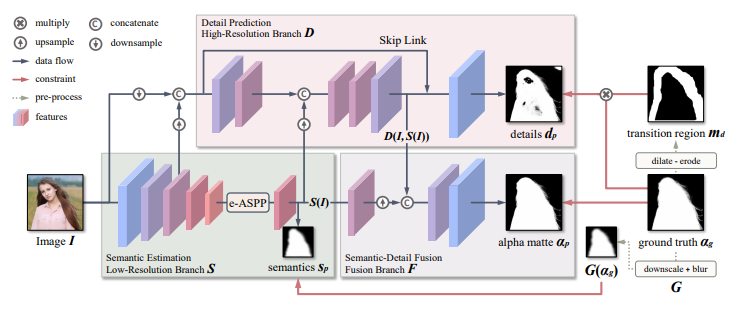

ASPP stands for Atrous Spatial Pyramid Pooling, this module extracts and fuses features depth wise first and then does inter channel fusion.   
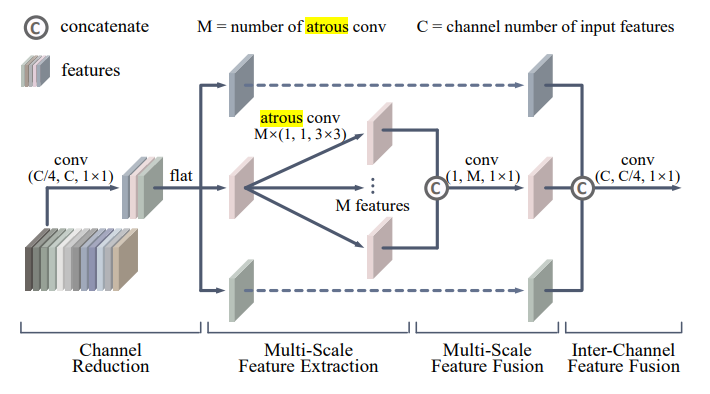

## Changes:-
Pretrained model VGG16 used for extracting high level features.

All activations made to sigmoid as it was observed that it gave better results

In [ ]:
class Sp(nn.Module):
  def __init__(self,vgg16,M=4):
    super(Sp,self).__init__()
    self.vgg = vgg16

    self.conv1 = nn.Conv2d(3,32,3,padding= 'same')
    self.act1 = nn.Sigmoid()
    self.max1 = nn.MaxPool2d(4)

    self.conv2 = nn.Conv2d(32,32,3,padding= 'same')
    self.act2 = nn.Sigmoid()
    self.max2 = nn.MaxPool2d(2)

    self.upsample1 = nn.Upsample(scale_factor = 2) #16x16
    self.convtrans1 = nn.ConvTranspose2d(512,128,(3,3),padding = 1)
    self.sig1 = nn.Sigmoid()
    self.upsample2 = nn.Upsample(scale_factor = 2) #32x32
    self.convtrans2 = nn.ConvTranspose2d(160,1,(3,3),padding = 1)
    self.sig2 = nn.Sigmoid()
    #self.thresh = nn.Threshold(0.5,0)

  def forward(self,X):
    #pretrained vgg for low level features
    V = self.vgg(X)
    
    #high level features
    X = self.conv1(X)
    X = self.act1(X)
    X = self.max1(X)
    X = self.conv2(X)
    X = self.act2(X)
    I = self.max2(X)


    
    X = self.upsample1(V)
    X = self.convtrans1(X)
    X = self.sig1(X)
    X = self.upsample2(X)

    #high + low level features
    X = torch.cat([X,I],1)
    X = self.convtrans2(X)
    X = self.sig2(X)



    return X

In [ ]:
class Dp(nn.Module):
  def __init__(self):
    super(Dp,self).__init__()
    self.conv1 = nn.Conv2d(3,64,(3,3),padding = 'same')
    self.max1 = nn.MaxPool2d(2) #128x128
    self.act1 = nn.Sigmoid()


    self.upsample_S = nn.Upsample(scale_factor = 2) 

    self.convtrans1 = nn.ConvTranspose2d(65,64,(3,3),padding = 1)
    self.act2 = nn.Sigmoid()


    self.upsample1 = nn.Upsample(scale_factor = 2) #256x256
    self.convtrans2 = nn.ConvTranspose2d(64,8,(3,3),padding = 1)
    self.act3 = nn.Sigmoid()


    self.upsample_Dp = nn.Upsample(scale_factor = 2) #512x512
    self.convtrans3 = nn.ConvTranspose2d(11,1,(3,3),padding=1)
    self.sig1 = nn.Sigmoid()
    #self.thresh = nn.Threshold(0.5,0)


  def forward(self,X,S):
    skip_conn = X

    X = self.conv1(X)
    X = self.act1(X)
    X = self.max1(X)

    S = self.upsample_S(S)
    X = torch.cat([X,S],1)

    X = self.convtrans1(X)
    X = self.act2(X)
    X = self.upsample1(X)
    X = self.convtrans2(X)
    X = self.act3(X)

    D_p = torch.cat([X,skip_conn],1)
    D_p = self.upsample_Dp(D_p)
    D_p = self.convtrans3(D_p)
    D_p = self.sig1(D_p)
    #D_p = self.thresh(D_p)

    self.D_p = D_p.clone()


    return X
  
  def getDp(self):
    return self.D_p

In [ ]:
class Fp(nn.Module):
  def __init__(self):
    super(Fp,self).__init__()

    self.upsample1 = nn.Upsample(scale_factor = 2)
    self.convtrans1 = nn.ConvTranspose2d(1,16,(3,3),padding = 1)
    self.act1 = nn.Sigmoid()


    self.upsample2 = nn.Upsample(scale_factor = 2)
    self.convtrans2 = nn.ConvTranspose2d(24,16,(3,3),padding = 1)
    self.act2 = nn.Sigmoid()


    self.upsample3 = nn.Upsample(scale_factor = 2)
    self.convtrans3 = nn.ConvTranspose2d(16,1,(3,3),padding = 1)
    self.sig1 = nn.Sigmoid()
    #self.thresh = nn.Threshold(0.5,0)


  def forward(self,S,D):
    S = self.upsample1(S)
    S = self.convtrans1(S)
    S = self.act1(S)

    S = self.upsample2(S)
    S = torch.cat([S,D],1)
    S = self.convtrans2(S)
    S = self.act2(S)

    S = self.upsample3(S)
    S = self.convtrans3(S)
    S = self.sig1(S)
    #S = self.thresh(S)


    return S

In [ ]:
class MODNet(nn.Module):
  def __init__(self,vgg16):
    super(MODNet,self).__init__()
    self.S = Sp(vgg16)
    self.D = Dp()
    self.F = Fp()
    self.max1 = nn.MaxPool2d(2)
    self.upsample1 = nn.Upsample(scale_factor = 2)

  def forward(self,X):
    I = X
    X = self.S(X)

    I = self.max1(I)

    D = self.D(I,X)
    F = self.F(X,D)
    details = self.D.getDp()
    return [F,X,details]

# Loss Function

This loss function is three fold as explained below -


1. Ld - This is the details loss that is calculated using the formula shown in the image below. This makes the model learn the fine details in the alpha matte (output). 

  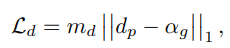 
2. L alpha - This is the loss found between the predicted alpha matte and the ground truth alpha matte. This difference is found using the L1 loss formula.

  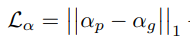
3. Ls - This finds the mean squared error between the downsampled and blurred alpha matte and the predicted semantics. This makes sure the model learns the high level details of the image. 

  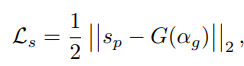

The final loss is the weighted sum of the above mentioned parts. The weights here being hyper-parameters. 



In [ ]:
class MODNet_Loss(nn.Module):
  def __init__(self):
    super(MODNet_Loss,self).__init__()
    self.L1 = nn.L1Loss()
    self.L1_1 = nn.L1Loss()
    self.L2 = nn.MSELoss()
  def forward(self, inputs, targets):
    

    Ls = self.L2(inputs[1],targets[1])/2 #(1/2)*||Sp-G(alphag)||2
    Ld = self.L1(inputs[2],targets[0])*targets[2]
    La = self.L1_1(inputs[0],targets[0])
    return torch.sum(Ls+ 10*Ld+ La)

In [ ]:
vgg = torchvision.models.vgg16(True)
vgg.cuda()
for param in vgg.parameters():
    param.requires_grad = False
summary(vgg.features,[[3,256,256]])

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [ ]:
model = MODNet(vgg.features)
if torch.cuda.is_available():
    model = model.cuda() # model.to("cuda:0")

criterion = MODNet_Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [ ]:
summary(model,(3,256,256),8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 256, 256]           1,792
              ReLU-2          [8, 64, 256, 256]               0
            Conv2d-3          [8, 64, 256, 256]          36,928
              ReLU-4          [8, 64, 256, 256]               0
         MaxPool2d-5          [8, 64, 128, 128]               0
            Conv2d-6         [8, 128, 128, 128]          73,856
              ReLU-7         [8, 128, 128, 128]               0
            Conv2d-8         [8, 128, 128, 128]         147,584
              ReLU-9         [8, 128, 128, 128]               0
        MaxPool2d-10           [8, 128, 64, 64]               0
           Conv2d-11           [8, 256, 64, 64]         295,168
             ReLU-12           [8, 256, 64, 64]               0
           Conv2d-13           [8, 256, 64, 64]         590,080
             ReLU-14           [8, 256,

# Training loop

The training was done with an learning rate of 3e-3 without weight decay. Adam optimizer was used to find the gradient and update the weights. 

The criterion used was the custom loss function desctibed earlier and was run for 5 epochs. 

The dataset used in this notebook is a Human segmentation dataset from AISegment.com. It contains 34427 images with their respective matting results.

500it [02:20,  3.54it/s]

[1,   500] loss: 262632.353


1000it [04:40,  3.55it/s]

[1,  1000] loss: 38640.394


1500it [07:00,  3.60it/s]

[1,  1500] loss: 23917.858


2000it [09:20,  3.59it/s]

[1,  2000] loss: 16250.734


2500it [11:40,  3.58it/s]

[1,  2500] loss: 12064.139


3000it [14:00,  3.52it/s]

[1,  3000] loss: 9816.244


3125it [14:35,  3.57it/s]


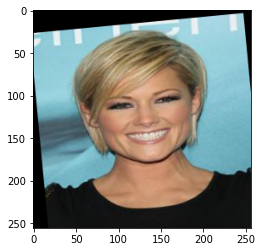

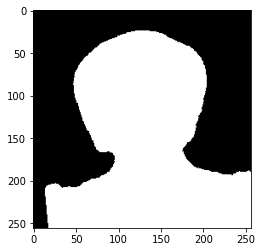

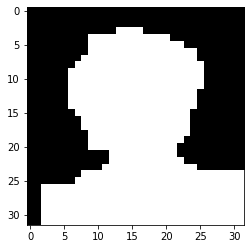

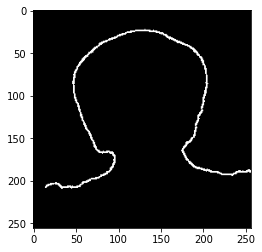

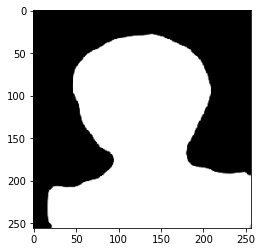

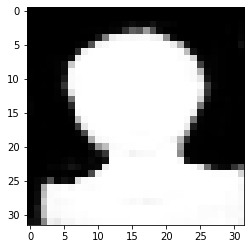

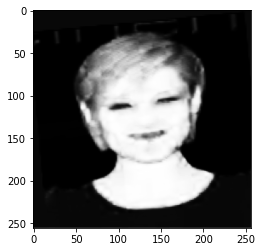



Epoch 1 training loss = 97721.63 Val Loss = 58316.44


500it [02:20,  3.58it/s]

[2,   500] loss: 57246.349


1000it [04:40,  3.56it/s]

[2,  1000] loss: 27987.834


1500it [07:01,  3.53it/s]

[2,  1500] loss: 18602.932


2000it [09:21,  3.56it/s]

[2,  2000] loss: 13606.436


2500it [11:42,  3.57it/s]

[2,  2500] loss: 10979.324


3000it [14:02,  3.54it/s]

[2,  3000] loss: 9030.879


3125it [14:37,  3.56it/s]


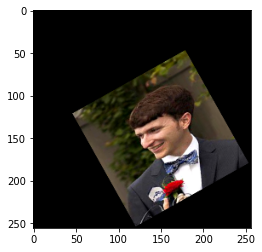

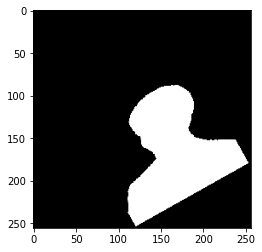

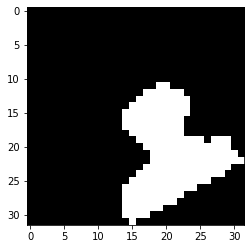

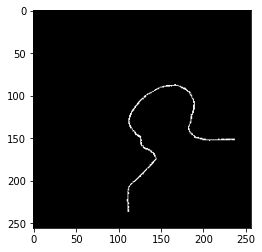

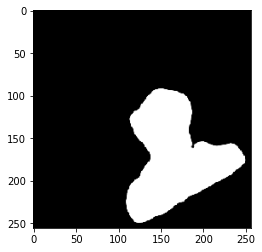

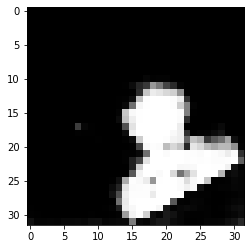

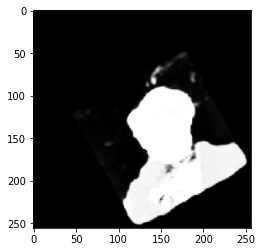



Epoch 2 training loss = 55167.84 Val Loss = 35501.62


500it [02:21,  3.58it/s]

[3,   500] loss: 30341.688


1000it [04:42,  3.49it/s]

[3,  1000] loss: 15225.353


1500it [07:03,  3.52it/s]

[3,  1500] loss: 9819.690


2000it [09:24,  3.57it/s]

[3,  2000] loss: 7241.823


2500it [11:45,  3.54it/s]

[3,  2500] loss: 5730.679


3000it [14:07,  3.50it/s]

[3,  3000] loss: 4577.567


3125it [14:42,  3.54it/s]


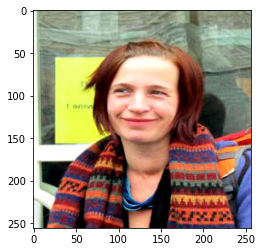

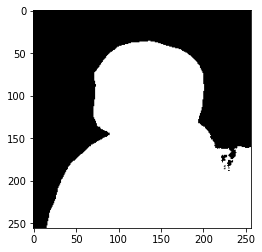

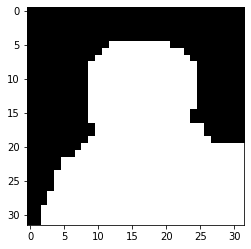

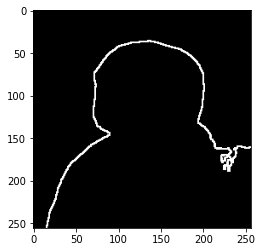

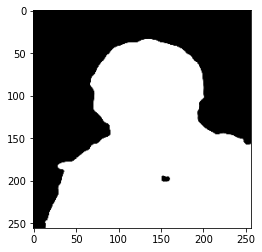

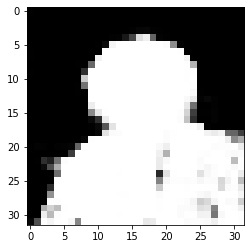

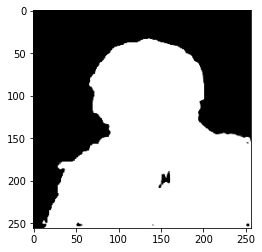



Epoch 3 training loss = 29171.18 Val Loss = 27562.83


500it [02:22,  3.49it/s]

[4,   500] loss: 27067.321


1000it [04:46,  3.51it/s]

[4,  1000] loss: 13169.875


1500it [07:09,  3.52it/s]

[4,  1500] loss: 8926.869


2000it [09:32,  3.43it/s]

[4,  2000] loss: 6422.884


2500it [11:55,  3.47it/s]

[4,  2500] loss: 5134.853


3000it [14:18,  3.51it/s]

[4,  3000] loss: 4296.223


3125it [14:54,  3.49it/s]


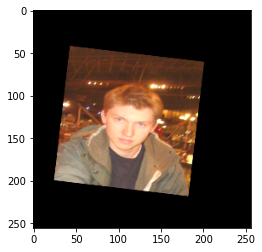

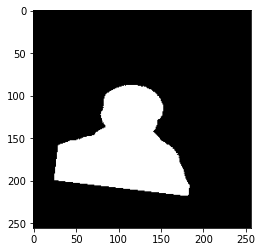

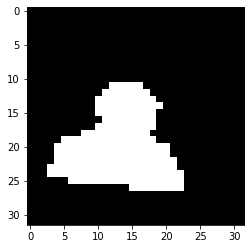

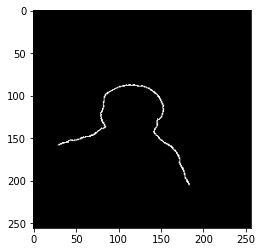

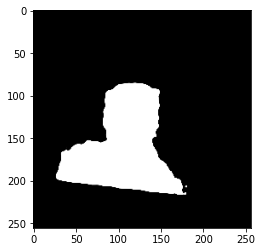

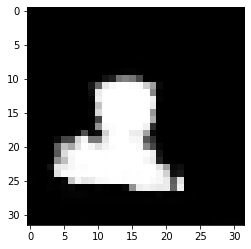

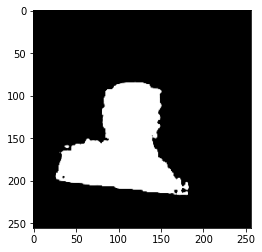



Epoch 4 training loss = 26201.14 Val Loss = 25205.43


500it [02:23,  3.48it/s]

[5,   500] loss: 25094.133


1000it [04:47,  3.45it/s]

[5,  1000] loss: 12440.408


1500it [07:11,  3.47it/s]

[5,  1500] loss: 8114.574


2000it [09:34,  3.52it/s]

[5,  2000] loss: 6049.012


2500it [11:57,  3.47it/s]

[5,  2500] loss: 4865.818


3000it [14:20,  3.51it/s]

[5,  3000] loss: 3918.044


3125it [14:55,  3.49it/s]


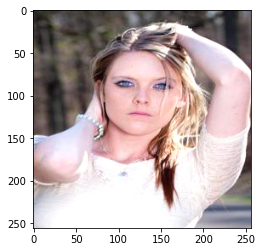

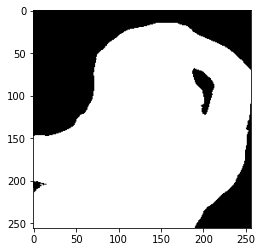

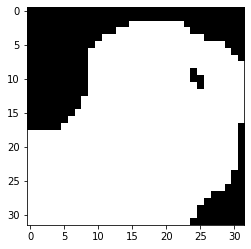

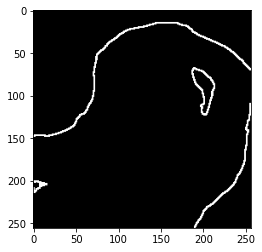

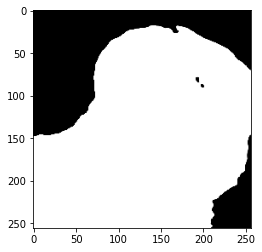

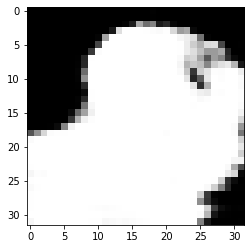

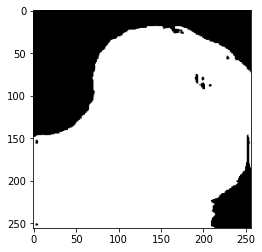



Epoch 5 training loss = 24398.96 Val Loss = 24906.43


In [ ]:
# Train the net

device = "cpu"
epochs = 5
if torch.cuda.is_available():
    device = "cuda"
history = [[],[]]
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    train_loss = 0.0
    epoch_steps = 0
    val_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0)):
          model.train()
          # get the inputs; data is a list of [inputs, mattes]
          inputs, images = data
          inputs, matte, semantics, transition = inputs, images[0], images[1], images[2]
          
          # forward + backward + optimize
          outputs = model(inputs)
          
          loss = criterion(outputs, [matte,semantics,transition])
          optimizer.zero_grad()
          loss.backward()
          
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          train_loss += loss.item()
          epoch_steps += 1
          #print(train_loss)
          if i % 500 == 499:  # print every 500 mini-batches
              print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                              running_loss / epoch_steps))
              running_loss = 0.0
              epoch_steps = 0
    plt.imshow(inputs[0].cpu().detach().permute(1,2,0).squeeze(2).numpy(),"gray")
    plt.show()
    plt.imshow(matte[0].cpu().detach().permute(1,2,0).squeeze(2).numpy(),"gray")
    plt.show()
    plt.imshow(semantics[0].cpu().detach().permute(1,2,0).squeeze(2).numpy(),"gray")
    plt.show()
    plt.imshow(transition[0].cpu().detach().permute(1,2,0).squeeze(2).numpy(),"gray")
    plt.show()
    plt.imshow(outputs[0][0].cpu().detach().permute(1,2,0).squeeze(2).numpy(),"gray")
    plt.show()
    plt.imshow(outputs[1][0].cpu().detach().permute(1,2,0).squeeze(2).numpy(),"gray")
    plt.show()
    plt.imshow(outputs[2][0].cpu().detach().permute(1,2,0).squeeze(2).numpy(),"gray")
    plt.show()
    print('\n')
    torch.save(model,"/content/6")
    for i, data in enumerate(val_loader, 0):
          model.eval()
          # get the inputs; data is a list of [inputs, mattes]
          inputs, images = data
          inputs, matte, semantics, transition = inputs, images[0], images[1], images[2]
          
          # evaluate batch
          outputs = model(inputs)
          
          loss = criterion(outputs, [matte,semantics,transition])
          
          # print statistics
          val_loss += loss.item()
    print(f"Epoch {epoch+1} training loss = {train_loss/len(train_loader):.2f} Val Loss = {val_loss/len(val_loader):.2f}")
    history[0].append(train_loss/len(train_loader))
    history[1].append(val_loss/len(val_loader))



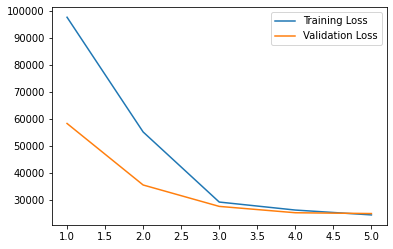

In [ ]:
 
plt.plot(range(1,epochs+1),history[0],label = "Training Loss")
plt.plot(range(1,epochs+1),history[1],label = "Validation Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(model,"/content/6-F")

#Testing

Consistency in the loss for the Train test and validation shows that the model is learning the correct features.

In [ ]:
test_loss = 0
for i, data in enumerate(test_loader, 0):
  model.eval()
  # get the inputs; data is a list of [inputs, labels]
  inputs, images = data
  inputs, matte, semantics, transition = inputs, images[0], images[1], images[2]
  
  # forward + backward + optimize
  outputs = model(inputs)
  
  loss = criterion(outputs, [matte,semantics,transition])
  
  # print statistics
  test_loss += loss.item()
print(f"test loss = {test_loss/len(test_loader):.2f}")

test loss = 24966.27


#Try on your own image xD

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


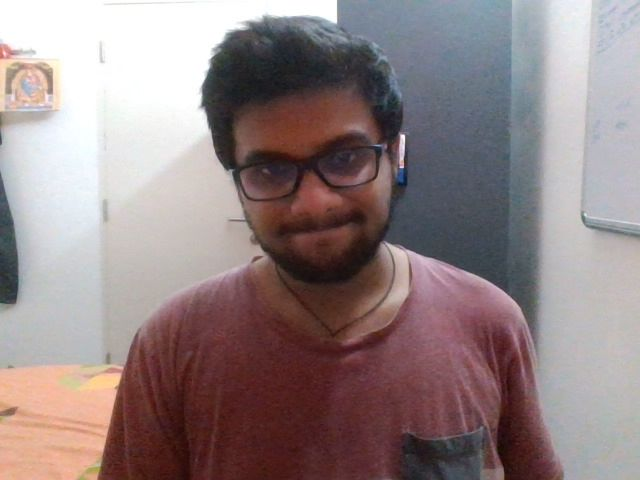

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
model = MODNet(vgg.features)

In [ ]:
model = torch.load("/content/6-F")
model = model.cuda()

In [ ]:

def pred(path):
  img = Image.open(path,'r').resize((256,256))
  img1 = np.array(img)/255
  img = np.array(img)/255
  
  img = torch.tensor(img,dtype = torch.float).permute(2,0,1).float().to("cuda")
  print(img.shape)
  out = model(img.unsqueeze(0))
  return out[0].cpu().detach().squeeze(2).numpy()[0][0],img1

In [ ]:
from PIL import Image,ImageFilter,ImageOps
out = pred("/content/photo.jpg")

torch.Size([3, 256, 256])


In [ ]:
out[0][out[0]<1] = 0
out[0][out[0]>=1] = 1
outm = np.repeat(out[0][:,:,np.newaxis],3,2)
outm.shape


(256, 256, 3)

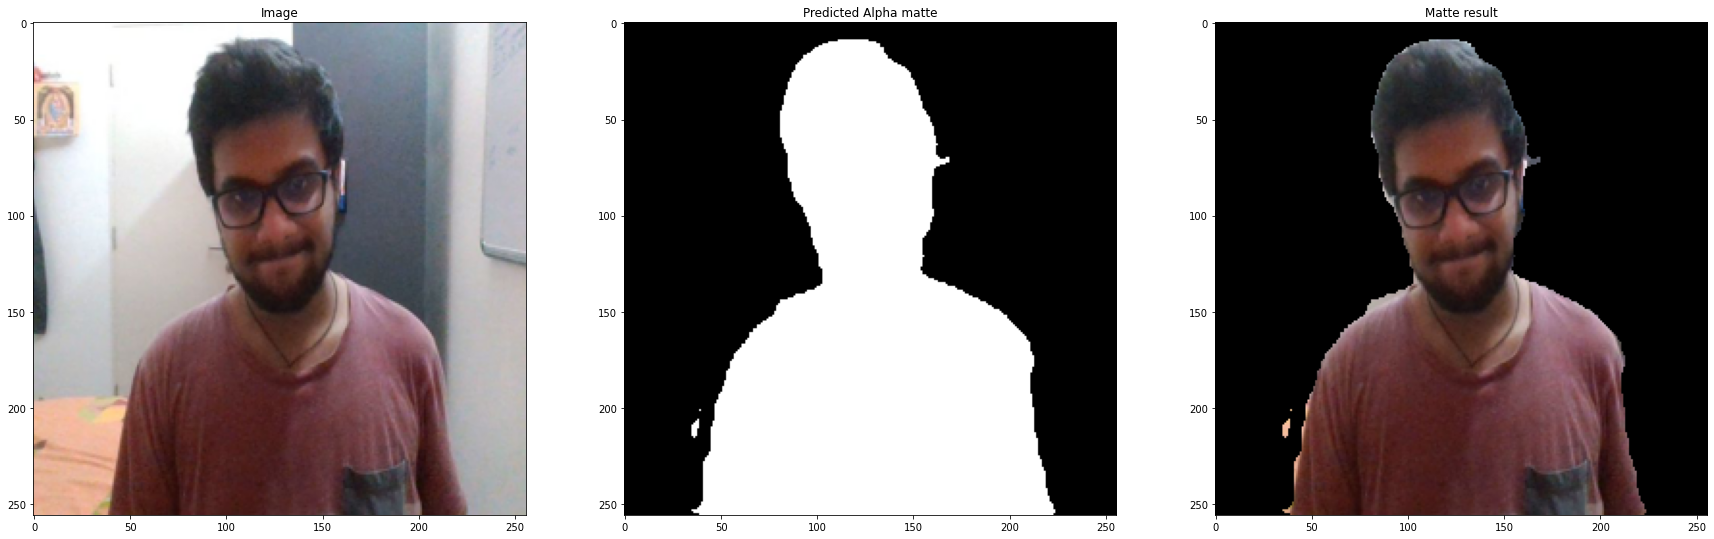

In [ ]:
f = plt.figure()
f.set_figheight(10)
f.set_figwidth(30)
plt.subplot(131)
plt.imshow(out[1])
plt.title("Image")
plt.subplot(132)
plt.imshow(out[0],"gray")
plt.title("Predicted Alpha matte")
plt.subplot(133)
plt.title("Matte result")
plt.imshow(out[1]*outm)
plt.show()

In [ ]:
torch.save(model,"/content/6-F")